## Grab Safety

<hr>

Based on telematics data, how might we detect if the driver is driving dangerously?

### Problem Statement

Given the telematics data for each trip and the label if the trip is tagged as dangerous driving, derive a model that can detect dangerous driving trips.

### Data Dict

<img src="../img/data dict.jpg" alt="Drawing" style="width: 600px;"/>

### Remark

This notebook is used to understand the given data set and explore and find the way to deal with the data. Moreover, this notebook is taking as the note on various sensors definitions and what are they.

In [1]:
# Core python library
import os
import gc
import pandas as pd
import numpy as np
from numpy import median
import math
import copy
import statsmodels.api as sm
pd.set_option('display.max_columns', 500)

# ignore the warning message
import warnings
warnings.filterwarnings('ignore')

# visualize related
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')
from IPython.display import display, HTML
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)

In [2]:
SEED = 1234
PATH = os.path.dirname(__file__) if "__file__" in locals() else os.getcwd()
os.chdir(PATH)
np.random.seed(SEED)

#### File exploration

The data is provided in `safety.zip`, the zip file contains __safety__ directory with the folders and files to process.

In [3]:
if not os.path.exists('../data/safety'):
    with zipfile.ZipFile('../data/safety.zip','r') as zip:
        zip.extractall('../data/')
        print('Extraction Done!')
        
else:
    print('Data is already available!!')

Data is already available!!


List all the features data stored in __safety/features__ directory.

In [4]:
def list_all_files_with_ext(path: str, 
                            suffix: str='.csv'):
    """
    Function to list all the files with specific extension in the given path
    @Args:
      path (str): the path to files
      suffix (str): the extension of the files to get; default: .csv
    Return: 
      List of files with given extensions in the path
    """
    filenames = os.listdir(path)
    return [path + filename for filename in filenames if filename.endswith(suffix)]


def read_files_(file_to_read: list, 
                show_sample_ind: bool=True):
    """
    Function to read multiple files onto one pandas dataframe
    @Args:
      file_to_read (list): List of path and filename to read
      show_sample_ind (bool): Show the head sample; default is True
    Return:
      full pandas dataframe
    """
    _df = pd.concat([pd.read_csv(f) for f in file_to_read], ignore_index=True)
    if show_sample_ind:
        display(_df.head(5))
        
    return _df


def get_missing_values(df: pd.DataFrame, 
                       return_missing_df_flag: bool=False):
    """
    Function to explore how many missing values (NaN) in the pandas
    @Args:
       df: pandas dataframe
       return_missing_df_flag: The boolean flag to return the missing pandas or not
       
    Return:
       Depends on the boolean flag; it will return the missing data table
    """
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)
    print("There are %s columns that have missing values" % str(mis_val_table_ren_columns.shape[0]))
    if return_missing_df_flag:
        return mis_val_table_ren_columns

Read all data into a single pandas. The data frame is quite large (approx. 16M rows). However, it only __consists of 20k unique booking ID__.

In [5]:
file_to_read = list_all_files_with_ext('../data/safety/features/')
data_df = read_files_(file_to_read)

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
0,1202590843006,3.000,353.0,1.228867,8.900100,3.986968,0.008221,0.002269,-0.009966,1362.0,0.000000
1,274877907034,9.293,17.0,0.032775,8.659933,4.737300,0.024629,0.004028,-0.010858,257.0,0.190000
2,884763263056,3.000,189.0,1.139675,9.545974,1.951334,-0.006899,-0.015080,0.001122,973.0,0.667059
3,1073741824054,3.900,126.0,3.871543,10.386364,-0.136474,0.001344,-0.339601,-0.017956,902.0,7.913285
4,1056561954943,3.900,50.0,-0.112882,10.550960,-1.560110,0.130568,-0.061697,0.161530,820.0,20.419409


In [6]:
print('The data frame dimensions: %s' % str(data_df.shape))
print('The unique booking ID: %s' % len(data_df.bookingID.unique()))

The data frame dimensions: (16135561, 11)
The unique booking ID: 20000


Next step is to check if there's any missing data and quick property of each feature.

In [7]:
get_missing_values(data_df)

There are 0 columns that have missing values


In [8]:
data_df.describe()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
count,1.613556e+07,1.613556e+07,1.613556e+07,1.613556e+07,1.613556e+07,1.613556e+07,1.613556e+07,1.613556e+07,1.613556e+07,1.613556e+07,1.613556e+07
mean,8.184819e+11,1.161035e+01,1.689684e+02,6.914529e-02,4.468976e+00,8.942974e-01,-1.710847e-03,2.800733e-04,-2.569688e-04,3.803484e+03,9.006543e+00
std,4.952476e+11,8.691672e+01,1.072966e+02,1.424161e+00,8.130664e+00,3.251549e+00,1.445619e-01,3.400630e-01,1.480824e-01,1.436686e+06,8.106415e+00
min,0.000000e+00,7.500000e-01,0.000000e+00,-7.841969e+01,-7.299412e+01,-7.844842e+01,-4.845575e+01,-7.488861e+01,-5.355445e+01,0.000000e+00,-2.000000e+00
25%,3.779571e+11,3.900000e+00,7.800000e+01,-5.081238e-01,-2.022476e+00,-9.316101e-01,-2.678888e-02,-2.993851e-02,-1.876500e-02,2.410000e+02,1.020000e+00
50%,8.074539e+11,4.250000e+00,1.688700e+02,6.137085e-02,9.081485e+00,7.757450e-01,-6.432411e-04,2.645046e-04,-3.542004e-05,5.200000e+02,7.530000e+00
75%,1.254130e+12,8.000000e+00,2.629840e+02,6.350620e-01,9.709778e+00,2.750938e+00,2.330639e-02,3.143085e-02,1.823425e-02,8.630000e+02,1.548000e+01
max,1.709397e+12,6.070101e+03,3.599995e+02,6.687346e+01,7.505589e+01,7.805576e+01,3.983975e+01,8.031496e+01,6.630078e+01,1.495797e+09,1.480186e+02


There are no missing on the given features data. Now let's go through the label data. Several steps I usually take are:

- Check the shape of the data
- Check missing data
- Show some sample records
- Check the key if there is any duplication in the key
- Check the label distribution

In [9]:
file_to_read = list_all_files_with_ext('../data/safety/labels/')
target_df = read_files_(file_to_read)

,bookingID,label
0,111669149733,0
1,335007449205,1
2,171798691856,0
3,1520418422900,0
4,798863917116,0


In [10]:
print('The target data shape: %s' % str(target_df.shape))
get_missing_values(target_df)
print('The unique booking ID: %s' % len(target_df.bookingID.unique()))

The target data shape: (20018, 2)
There are 0 columns that have missing values
The unique booking ID: 20000


Hmmm... We have the target data frame with 20,018 rows but with unique _bookingID_ of 20,000. Now I will focus specific on those with duplicated labels.

- __Observation__: These bookingIDs have both labels presented (0 and 1).

In [11]:
target_df[target_df.duplicated(['bookingID'], keep=False)].sort_values(by=['bookingID', 'label']).T

,12463,12602,5295,2351,6212,11215,19936,6121,8472,17623,10778,2858,18027,11058,16462,17843,10880,17001,18951,11133,2721,13634,6210,6168,16990,3068,9979,14942,9483,16340,6516,1256,14432,1059,19453,13688
bookingID,13,13,154618822837,154618822837,223338299461,223338299461,395136991308,395136991308,403726925929,403726925929,455266533495,455266533495,481036337234,481036337234,515396075694,515396075694,695784702084,695784702084,919123001348,919123001348,970662608932,970662608932,1279900254294,1279900254294,1348619731077,1348619731077,1391569403991,1391569403991,1408749273124,1408749273124,1511828488211,1511828488211,1632087572573,1632087572573,1649267441751,1649267441751
label,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1


In this case, I will assume that these group of booking IDs are marked as dangerous (label = 1). This implementation is based on several assumptions like;

1. The same booking ID is ultimately meaning that it is the same trip for the same driver. Even though some data capture is missing from the trip.

2. The flagging of the trip __does not__ consist the time stamp, hence, any trip has label of 1 will be assumed to be priority. Because even the same trip has both labels, we need to care more about the safety.

In [12]:
target_df.loc[target_df.duplicated(['bookingID'], keep=False), 'label'] = 1
target_df.drop_duplicates(subset=['bookingID', 'label'], keep='first', inplace=True)
target_df.reset_index(drop=True, inplace=True)
print(target_df.shape)

(20000, 2)


With this fix, I will have equal __unique__ booking IDs for both features and targets data.

In [13]:
np.array_equal(np.sort(data_df.bookingID.unique()) , np.sort(target_df.bookingID.unique()))

True

Now we can use the cleansed target to see the given label distribution.

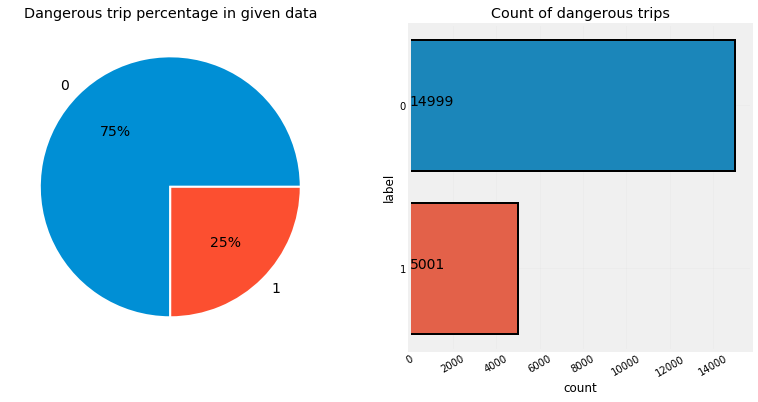

In [14]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
target_df["label"].value_counts().plot.pie(autopct  = "%1.0f%%",
                                           fontsize = 14,
                                           wedgeprops = {"linewidth": 2,
                                                         "edgecolor": "w"}
                                          )                     
plt.title("Dangerous trip percentage in given data")
plt.ylabel("")
plt.subplot(122)
ax = sns.countplot(y = target_df["label"], linewidth = 2, 
                   edgecolor = "k"*target_df["label"].nunique())
for i,j in enumerate(target_df["label"].value_counts().values): 
    ax.text(.1, i, j, fontsize=14, color="k")
    
plt.title("Count of dangerous trips")
plt.xticks(rotation=30)
plt.grid(True, alpha=.1)
plt.show()

Now, we have built and cleansed the target data frame. For the sake of further analysis, I will merge target onto the feature data set.

In [15]:
full_df = pd.merge(data_df, target_df, on='bookingID', how='left')

#### Data Understanding

Now, we have both features and targets data set. In this section, I will deep dive onto the features data to get a better understanding from it.

- __bookingID__: trip ID
- __Accuracy__: accuracy inferred by GPS in meters
- __Bearing__: GPS bearing in degree
- __acceleration_x__: accelerometer reading at x axis $m / s^2$
- __acceleration_y__: accelerometer reading at y axis $m / s^2$
- __acceleration_z__: accelerometer reading at z axis $m / s^2$
- __gyro_x__: gyroscope reading in x axis $ rad / s$
- __gyro_y__: gyroscope reading in y axis $ rad / s$
- __gyro_z__: gyroscope reading in z axis $ rad / s$
- __Second__: time of the record by number of seconds
- __Speed__: speed measured by GPS in $ m / s$
- __label__: the target variable of dangerous driving (0 = safe, 1 = danger)


The given data is time-series data coming from each booking / trip. As such, we can sort the data set by bookingID and second, and we can view each individual trip correcly.

In [16]:
data_df.sort_values(by=['bookingID', 'second'], ascending=True, inplace=True)
data_df.reset_index(inplace=True, drop=True)
display(data_df.head(5))

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
0,0,12.0,143.298294,0.818112,-9.941461,-2.014999,-0.016245,-0.094040,0.070732,0.0,3.442991
1,0,8.0,143.298294,0.546405,-9.835590,-2.038925,-0.047092,-0.078874,0.043187,1.0,0.228454
2,0,8.0,143.298294,-1.706207,-9.270792,-1.209448,-0.028965,-0.032652,0.015390,2.0,0.228454
3,0,8.0,143.298294,-1.416705,-9.548032,-1.860977,-0.022413,0.005049,-0.025753,3.0,0.228454
4,0,8.0,143.298294,-0.598145,-9.853534,-1.378574,-0.014297,-0.046206,0.021902,4.0,0.228454


__Observation__

- Not all the data is captured for the whole trip, as we can see from the sample bookingID (0), the speed of the GPS is still traveling (and without further increasing of acceleration and gyro, this can be noted that the car is heading forward).

In [17]:
data_df.loc[data_df.bookingID == 0, :].tail(5)

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
999,0,8.0,1.318084,-0.928021,-9.903479,0.174359,-0.072805,-0.044613,-0.067651,1585.0,14.514922
1000,0,8.0,1.318084,-1.458725,-9.134714,-1.335059,0.024747,0.060531,-0.002654,1586.0,15.799594
1001,0,8.0,1.318084,-0.671866,-10.223337,-1.004584,-0.009690,-0.098571,0.014922,1587.0,16.543667
1002,0,8.0,1.318084,-0.269464,-10.234253,-1.925577,-0.042335,-0.064177,-0.044309,1588.0,16.543667
1003,0,8.0,1.318084,-1.938287,-8.782108,-1.037183,0.020958,-0.054220,0.013748,1589.0,17.500950


We can then summarize to see how many records for each booking ID and do we truly have all seconds associated with each of them. 

__Are the sensors records all the seconds for each trip?__

Assumption is `max(seconds)` represents the ending trip

In [18]:
booking_agg_df = data_df[['bookingID', 'second']].groupby('bookingID').\
agg({'second': ['count', np.min, np.max]})
cols = {'second_count': 'rec_cnt',
        'second_amin': 'min_sec',
        'second_amax': 'max_sec'
       }
booking_agg_df.columns = booking_agg_df.columns.map('_'.join).to_series().map(cols)
booking_agg_df.reset_index(inplace=True)
display(booking_agg_df.head(3))

,bookingID,rec_cnt,min_sec,max_sec
0,0,1004,0.0,1589.0
1,1,851,0.0,1034.0
2,2,195,0.0,825.0


All the `second` value starts from 0 based on below script.

In [19]:
np.min(booking_agg_df.min_sec), np.max(booking_agg_df.min_sec)

(0.0, 0.0)

Let's quickly join the target labels with this data frame `booking_agg_df`.

In [20]:
rec_chk_df = booking_agg_df.merge(target_df, on='bookingID', how='left')
rec_chk_df['full_rec_ind'] = np.where(rec_chk_df.rec_cnt == (rec_chk_df.max_sec + 1.), 1, 0)
rec_chk_df['percent_diff'] = np.round(rec_chk_df['rec_cnt'] / (rec_chk_df['max_sec']+1.) - 1, 6)

display(rec_chk_df.head(3))
get_missing_values(rec_chk_df)

,bookingID,rec_cnt,min_sec,max_sec,label,full_rec_ind,percent_diff
0,0,1004,0.0,1589.0,0,0,-0.368553
1,1,851,0.0,1034.0,1,0,-0.177778
2,2,195,0.0,825.0,1,0,-0.763923


There are 0 columns that have missing values


Roughly 25% of the provided data has the full records (0 to `max(second)`).

In [21]:
np.bincount(rec_chk_df.full_rec_ind)

array([15028,  4972], dtype=int64)

Mostly, the given data is not completed and has some lagged different around 3-7% range. However, there is some records which has more than 50% missing recording seconds.

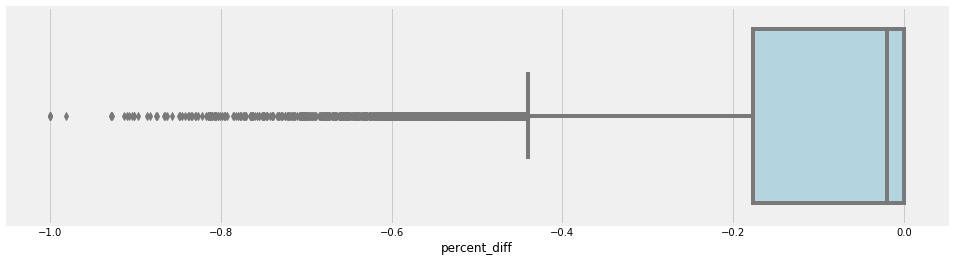

In [22]:
plt.figure(figsize=(15, 4))
sns.boxplot(x="percent_diff", data=rec_chk_df, color='lightblue', orient='h')
plt.show();

#### Introduction to sensor world!!

Our given data is called **Telematics** data, this data is mostly coming from __accelerometer__ and __gyroscope__ and some other sensor data (such as Magnetometer or compass, GPS).

<br>

Let's explore each of the given data set.

__Bearing__

GPS bearing is the compass direction from driver's current position to the intended destination. In other words, it describes the direction of a destination or object. If you're facing due north, and want to move toward a building directly to your right, the bearing would be east.

It is calculated as an __angle measured in degrees in a clockwise direction from true north__. The angle's vertex represents your location, while the two rays point north and toward your goal destination.

Based on this, the ranges of value should be from 0 to 360 degree.

In [23]:
[np.min(data_df.Bearing), np.max(data_df.Bearing)]

[0.0, 359.9994812011719]

__Acceleration__

- If you are not changing speed and direction, you are not accelerating.
- velocity describes how position changes; acceleration describes how velocity changes

<img src="../img/acceleration_mobile.jpg" alt="Drawing" style="float: left; width: 300px;"/>

<img src="../img/acceleration_mobile_orient_2.jpg" alt="Drawing" style="float: left; width: 250px;"/>

With this, if the mobile phone is placed on the table face up, the Z-axis will measure the acceleration of the Earth gravity and outputs around 9.81 in $m/s^2$.

Or if mobile phone is placed  on the stand, the Y-axis will measure Earth's gravity instead (as per the figure).

<br><br><br><br><br><br>

- An object in free-fall would as such have no acceleration affecting it while an object at rest on the surface of the earth would experience an acceleration of 9,81 m/s2 upwards due to the surface pushing the object upwards to negate gravity. 
- Accelerometers in smartphones bases their functionality on micro-electromechanical-systems (MEMS), which measure electric currents based on compression of a seismic mass, often silicon, caused by acceleration.
- If the phone is fixated in place inside the car, which means that ideally, the phone will ___never___ move relative to the car.
- If the accelerometer detects a __negative acceleration__ along the y-axis, it should mean that the phone is currently pointing down towards the centre of the earth (or the car is on its roof).
- If the accelerometer detects a significant __accelerating along the x-axis__, it assumes that the car is on its side.
- Detect either __high G-forces__ or __bad car-orientation__.
- 1 g = 9.81 $\frac{m}{s^2}$

In [24]:
data_df.groupby('bookingID').agg({'acceleration_x': [np.min, np.max], 
                                  'acceleration_y': [np.min, np.max],
                                  'acceleration_z': [np.min, np.max]}).head(5)

acceleration_x           acceleration_y            acceleration_z  \
                    amin      amax           amin       amax           amin   
bookingID                                                                     
0              -4.692294  4.782614     -12.764703  -6.119916      -6.251807   
1              -5.352994  3.813341       6.623425  12.536156      -5.355455   
2              -2.971295  1.956122       7.941810  13.333716      -3.282551   
4              -2.866458  2.019635     -18.847833  -7.064984      -9.374869   
6              -4.352792  5.593026       6.469330  13.249917      -2.140482   

                     
               amax  
bookingID            
0          2.318857  
1          1.481293  
2          2.312870  
4          0.296381  
6          7.977724

With each acceleration in the 3-D axis, we can compute the total magnitude of the acceleration using `Pythagorean Theorem`.

In [25]:
def compute_magnitude_3D(x: float, y: float, z: float):
    """
    Function to compute the total magnitude in 3-dimension space
    @Args: 
      x (float): the acceleration from the x-axis
      y (float): the acceleration from the y-axis
      z (float): the acceleration from the z-axis
      
    Return:
      The total magnitude value from 3-dimension space
    """
    return np.sqrt(x**2 + y**2 + z**2)


data_df['total_magnitude'] = data_df.apply(lambda x: compute_magnitude_3D(x.acceleration_x,
                                                                          x.acceleration_y,
                                                                          x.acceleration_z
                                                                         ), axis=1)
display(data_df.head(3))

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed,total_magnitude
0,0,12.0,143.298294,0.818112,-9.941461,-2.014999,-0.016245,-0.094040,0.070732,0.0,3.442991,10.176551
1,0,8.0,143.298294,0.546405,-9.835590,-2.038925,-0.047092,-0.078874,0.043187,1.0,0.228454,10.059553
2,0,8.0,143.298294,-1.706207,-9.270792,-1.209448,-0.028965,-0.032652,0.015390,2.0,0.228454,9.503762


__Magnetometer__

- Compass, for short. Can determine which way is north
- can affected by lots of metal nearby
- Together with Accelerometer can orient the phone with respect to the planet. But cannot tell if the phone is moving in one steady direction

__Gyroscope__

- Measure change in orientation (partially duplicates the capability of accelerometer and magnetometer).

- Gyro adds an additional dimension to the information supplied by the accelerometer by tracking _rotation_ or __twist__ (or angular rotational velocity). Detects rotational speed around each axis of the phone. In practice, that means the accelerometer will measure the directional movement of a device but will not be able to resolve its lateral orientation or tilt during that movement accurately unless  a gyro is there to fill in that info.

- By using a timestep and multiplying the timestep with rotational speed from the gyroscope, it is possible to calculate how many radians the phone has rotated during the timestep to detect __rotations over short periods of time__.

- gyroscope is set to only detect rotations over short durations, e.g. a few seconds, to determine if the car has lost control or not.

- In this data set, gyro value provided in $rad / s$

In [27]:
data_df.groupby('bookingID').agg({'gyro_x': [np.min, np.mean, np.median, np.max], 
                                  'gyro_y': [np.min, np.mean, np.median, np.max],
                                  'gyro_z': [np.min, np.mean, np.median, np.max]}).head(10)

gyro_x                                  gyro_y            \
               amin      mean    median      amax      amin      mean   
bookingID                                                               
0         -0.392537  0.003328  0.002575  0.438371 -0.609930 -0.006118   
1         -0.125367 -0.002467 -0.001518  0.126536 -0.678183 -0.007540   
2         -0.155218  0.006458  0.001164  0.282162 -0.462000 -0.012861   
4         -0.420507 -0.022884 -0.022799  0.438732 -0.506531  0.023232   
6         -0.253551  0.003877  0.000569  0.362202 -0.621802  0.000436   
7         -0.404445 -0.003932 -0.008553  0.934745 -0.299363  0.003424   
8         -0.216751  0.004716  0.003174  0.347733 -0.360397 -0.000694   
10        -0.339844 -0.001418  0.000824  0.198120 -0.498840  0.002311   
11        -0.539777  0.005530  0.006337  0.619034 -0.480144 -0.004115   
13        -0.214795 -0.002206 -0.001604  0.124235 -0.396778  0.009890   

                                 gyro_z                                
             median      amax      amin      mean    median      amax  
bookingID                                                              
0         -0.002239  0.469724 -0.731892 -0.004188 -0.003522  0.372807  
1         -0.003491  0.470837 -0.121265  0.000405 -0.000384  0.235131  
2          0.001035  0.431695 -0.125907  0.002597  0.001764  0.255884  
4          0.024504  0.652628 -0.348189 -0.000376 -0.001147  0.505220  
6          0.003724  0.532123 -0.348345  0.002930  0.002902  0.364534  
7         -0.001222  0.651267 -0.852878 -0.005800 -0.003666  0.532744  
8          0.000320  0.387100 -0.088150 -0.001139  0.000168  0.070053  
10        -0.000244  0.430710 -0.134918 -0.001383 -0.000946  0.259216  
11        -0.001226  0.530838 -0.265598  0.003009  0.000739  0.267076  
13         0.006393  0.477370 -0.190635  0.005380  0.003620  0.158780

As we can see, there're not much rotation during each trip (bookingID). However, there're fraction different among `maximum` value, `minimum` value and the `median`.

__GPS__

- Passive electronic antenna
- identifies location of phone on planet
- used to get __velocity__

[Reference on GPS](https://www.gps.gov/systems/gps/performance/accuracy/#speed)

Now, let's visualize some trip randomly to see how the sensors and data reacted.

In [28]:
def plot_all_per_booking(data_df:pd.DataFrame, booking_id:int =0):
    """
    Function to visualize the data corresponding to the given booking ID
    @Args:
      data_df (pd.DataFrame): pandas data containing the full data with specified booking_id
      booking_id (int): the ID represented the trip / booking
    
    Return:
      No object returned, only visualization on console
    """
    _tmp = data_df.loc[data_df.bookingID == booking_id, :]
    _tmp_acc = _tmp[['second', 'acceleration_x', 'acceleration_y', 'acceleration_z']]
    _tmp_acc.set_index('second', inplace=True)
    _tmp_gyro = _tmp[['second', 'gyro_x', 'gyro_y', 'gyro_z']]
    _tmp_gyro.set_index('second', inplace=True)
    _tmp_other = _tmp[['second', 'Accuracy', 'Bearing', 'Speed']]
    _tmp_other.set_index('second', inplace=True)
    fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
    if 'label' in _tmp.columns:
        _lab = _tmp['label'].unique()[0]
        fig.suptitle('BookingID: %s and Label: %s' % (str(booking_id), _lab), 
                                                      fontsize=18)
    else:
        fig.suptitle('BookingID: %s' % str(booking_id), fontsize=18)
        
    sns.lineplot(data=_tmp_acc, ax=axes[0], linewidth=1.5, alpha=.8)
    axes[0].set_title('Accerelation along the time (m/s2)', fontsize=12)
    axes[0].legend(frameon=False, loc='best', ncol=3)
    sns.lineplot(data=_tmp_gyro, ax=axes[1], linewidth=1.5, alpha=.8)
    axes[1].set_title('Gyro along the time (m/s2)', fontsize=12)
    axes[1].legend(frameon=False, loc='best', ncol=3)
    plt.tight_layout()
    plt.subplots_adjust(top=.93)
    plt.show()
    fig, axes = plt.subplots(3, 1, figsize=(12, 8))
    sns.lineplot(x=_tmp_other.index, y=_tmp_other.Accuracy, linewidth=1.5, ax=axes[0])
    sns.lineplot(x=_tmp_other.index, y=_tmp_other.Bearing, linewidth=1.5, ax=axes[1])
    sns.lineplot(x=_tmp_other.index, y=_tmp_other.Speed, linewidth=1.5, ax=axes[2])
    plt.show();
    


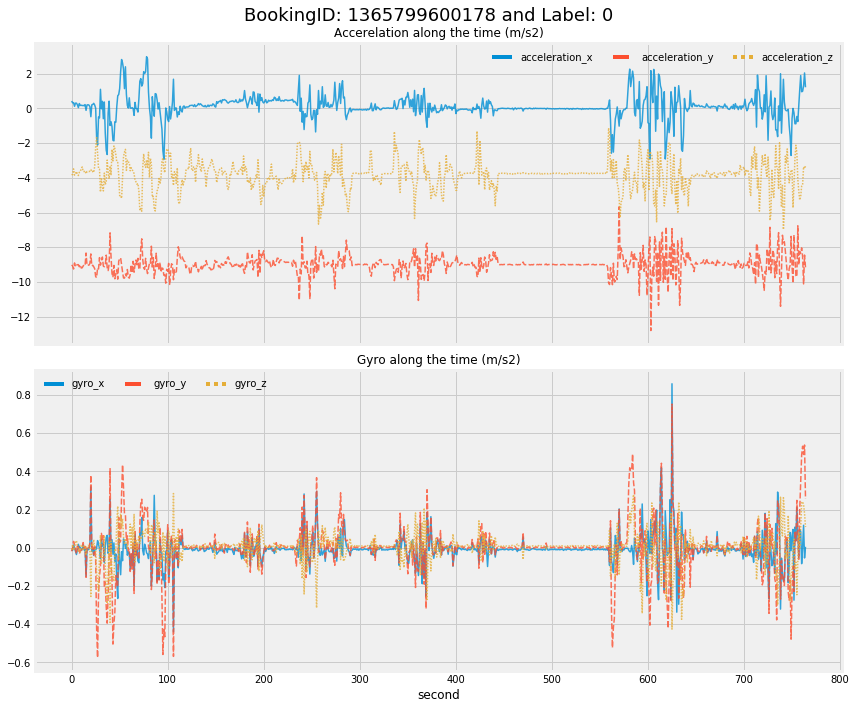

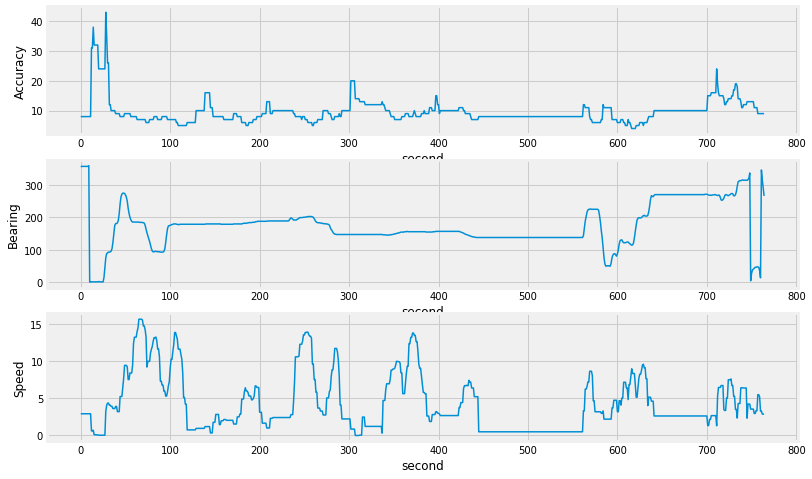

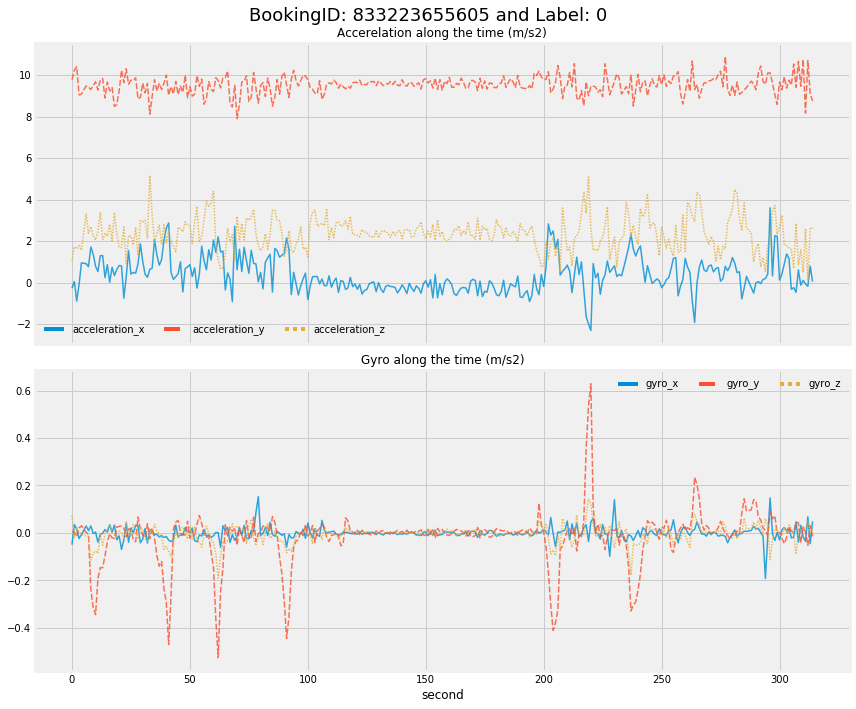

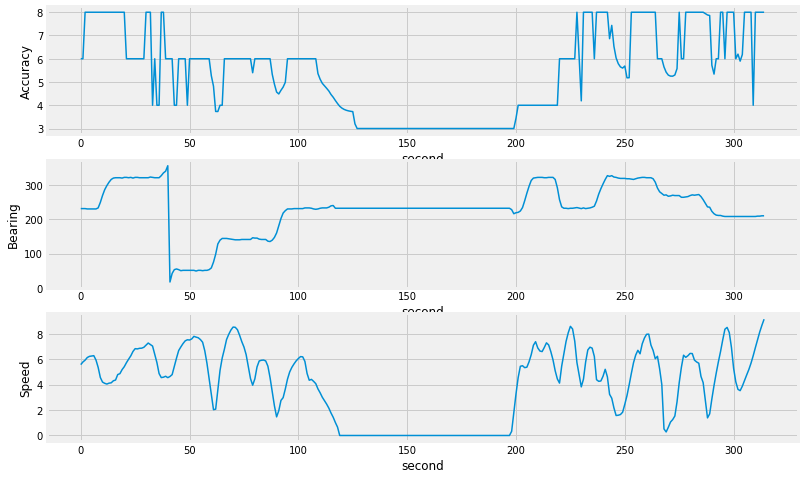

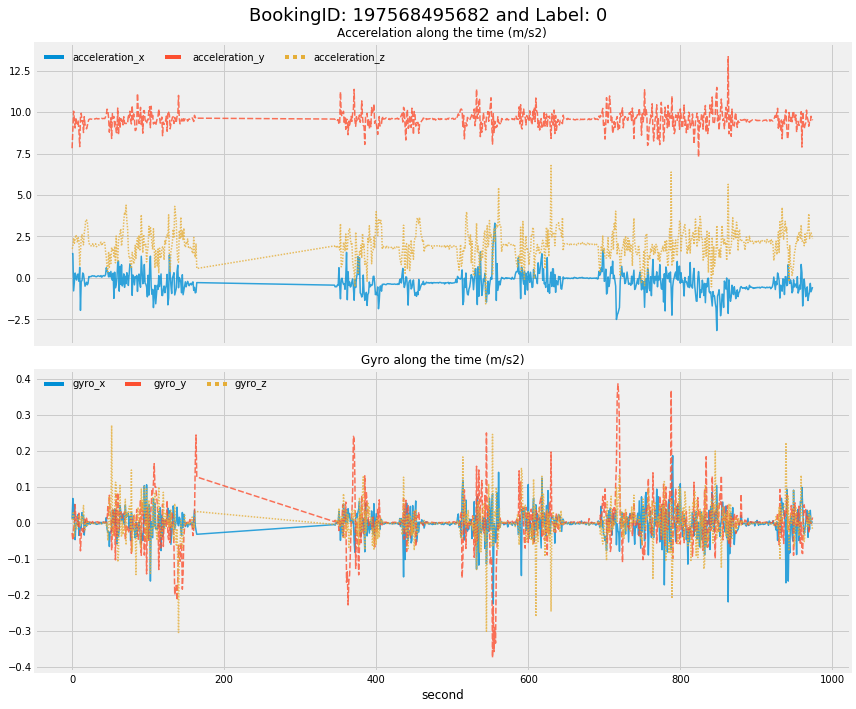

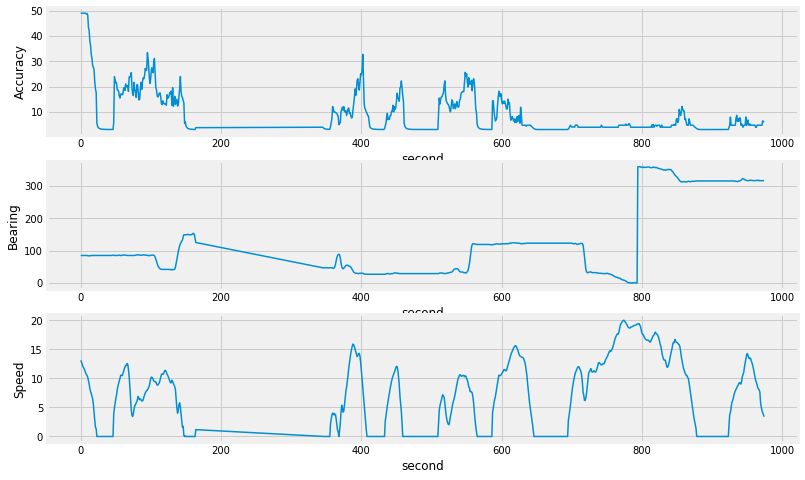

In [29]:
np.random.seed(SEED)
for i in np.random.choice(full_df.bookingID.unique(), size=3, replace=False):
    plot_all_per_booking(full_df, i)

And some plots for the trips with full records (number of records matched with `max(second)`.

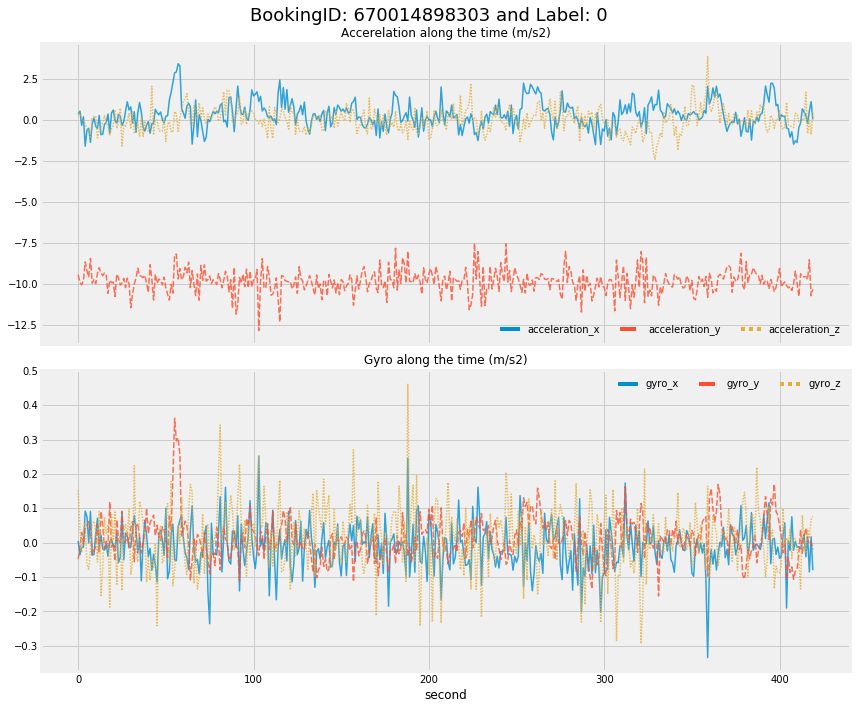

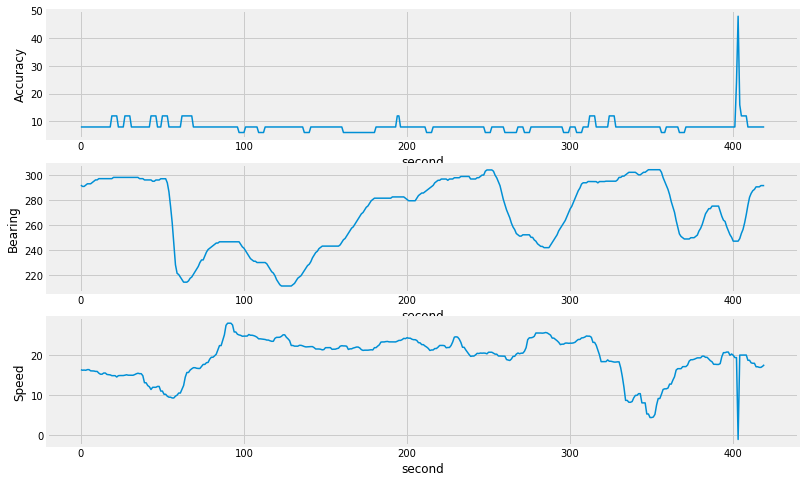

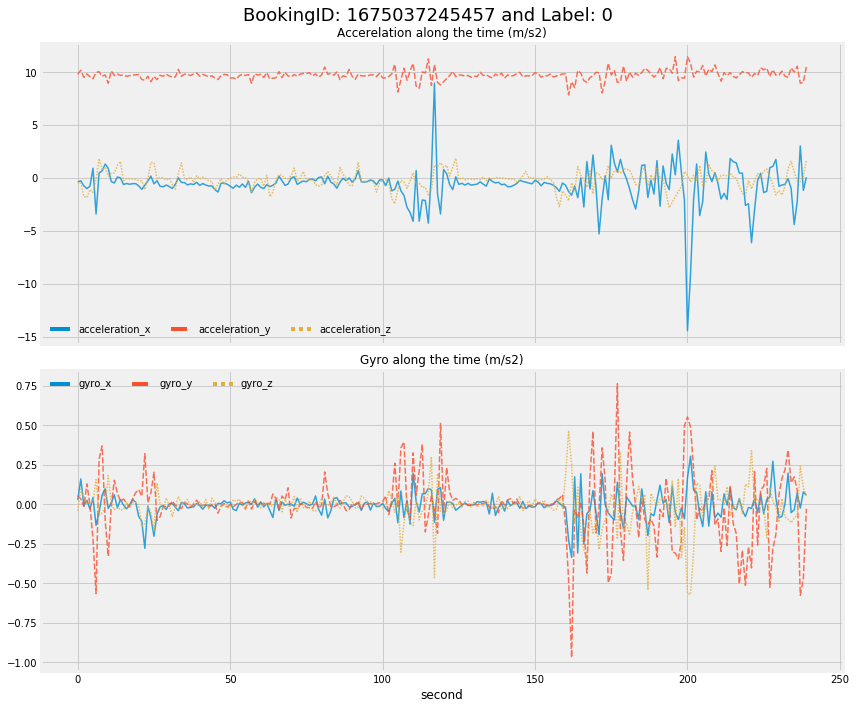

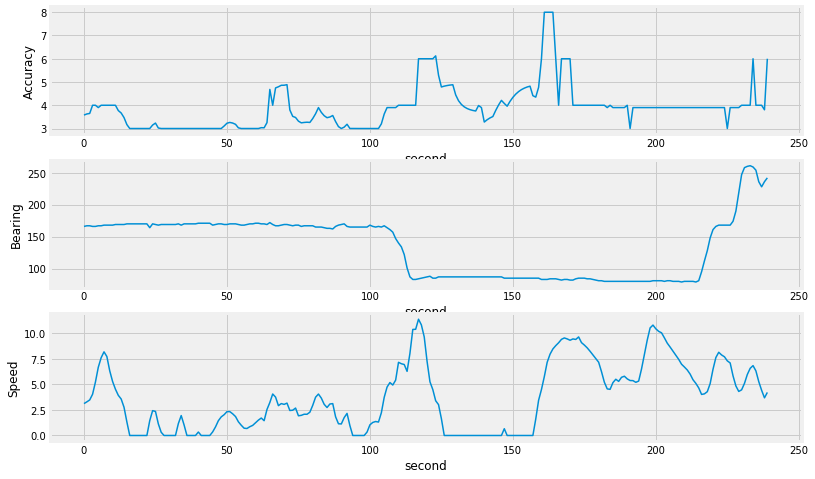

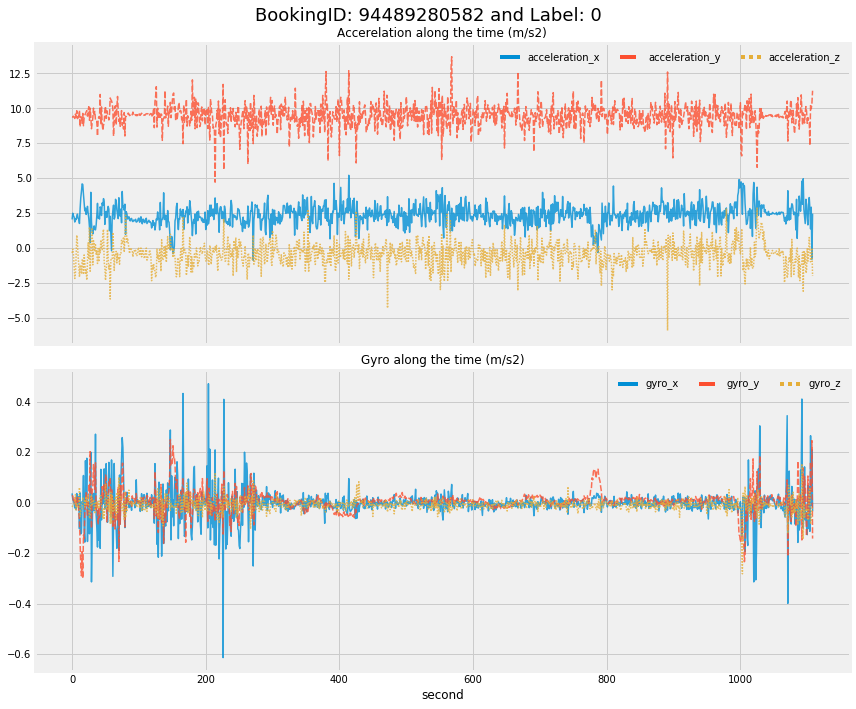

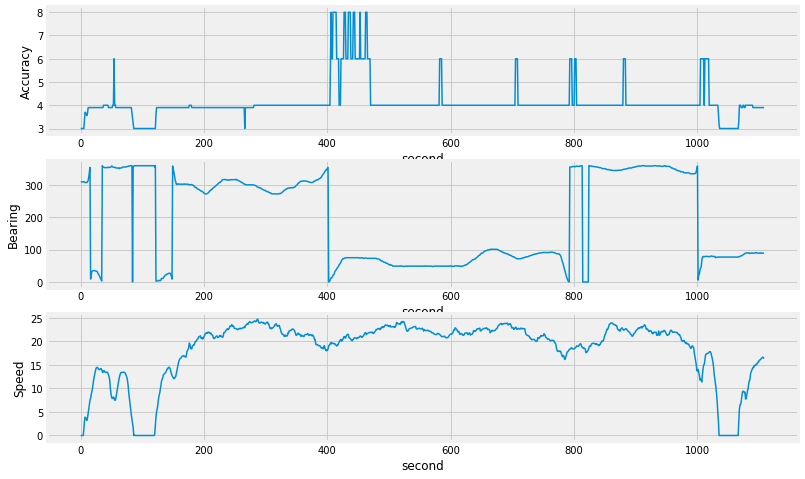

In [30]:
np.random.seed(SEED)
for i in np.random.choice(rec_chk_df.loc[rec_chk_df.full_rec_ind == 1, 'bookingID'].unique(), 
                          size=3, replace=False):
    plot_all_per_booking(full_df, i)

__Can we convert the gyro measurement to be more interpretable value?__

Convert the radian per second to degree per second.

$1.2 rad = 1.2 * \frac{180°}{\pi} = 68.754935416°$

<img src="../img/angle_rad_to_degree.jpg" alt="Drawing" style="float: left; width: 100px;"/>

<br>
<br>
The image on the left show 1.2 radian or 68.75 degree

In [31]:
def convert_rad_to_degree(data_df, col_pattern:str):
    out_df = copy.deepcopy(data_df)
    _out_array = data_df[col_pattern].apply(math.degrees)
    return  _out_array

data_df['gyro_x_degree'] = convert_rad_to_degree(data_df, 'gyro_x')
data_df['gyro_y_degree'] = convert_rad_to_degree(data_df, 'gyro_y')
data_df['gyro_z_degree'] = convert_rad_to_degree(data_df, 'gyro_z')
display(data_df.head(10))

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed,total_magnitude,gyro_x_degree,gyro_y_degree,gyro_z_degree
0,0,12.0,143.298294,0.818112,-9.941461,-2.014999,-0.016245,-0.094040,0.070732,0.0,3.442991,10.176551,-0.930756,-5.388123,4.052673
1,0,8.0,143.298294,0.546405,-9.835590,-2.038925,-0.047092,-0.078874,0.043187,1.0,0.228454,10.059553,-2.698166,-4.519165,2.474442
2,0,8.0,143.298294,-1.706207,-9.270792,-1.209448,-0.028965,-0.032652,0.015390,2.0,0.228454,9.503762,-1.659576,-1.870834,0.881790
3,0,8.0,143.298294,-1.416705,-9.548032,-1.860977,-0.022413,0.005049,-0.025753,3.0,0.228454,9.830320,-1.284180,0.289261,-1.475510
4,0,8.0,143.298294,-0.598145,-9.853534,-1.378574,-0.014297,-0.046206,0.021902,4.0,0.228454,9.967466,-0.819138,-2.647385,1.254868
5,0,8.0,143.298294,-0.608313,-9.539658,-1.794583,-0.007538,-0.023838,0.018068,5.0,0.228454,9.726029,-0.431900,-1.365799,1.035233
6,0,8.0,143.298294,-0.867758,-9.698615,-1.615439,0.022728,-0.012178,0.005982,6.0,0.228454,9.870449,1.302200,-0.697739,0.342758
7,0,8.0,143.298294,-1.050790,-9.745270,-1.411771,0.027603,0.001841,0.000904,7.0,0.228454,9.902906,1.581558,0.105484,0.051819
8,0,8.0,143.298294,-0.721213,-9.960004,-1.202271,0.001864,-0.007702,0.014018,8.0,0.228454,10.058194,0.106781,-0.441284,0.803177
9,0,8.0,143.298294,-0.346924,-9.532629,-1.204663,0.014962,-0.050033,0.025118,9.0,0.228454,9.614707,0.857269,-2.866699,1.439163


In [32]:
data_df.loc[data_df.gyro_x_degree == max(data_df.gyro_x_degree), :]

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed,total_magnitude,gyro_x_degree,gyro_y_degree,gyro_z_degree
6524460,644245094400,5.36,78.0,-8.434937,5.121536,3.117294,39.83975,-23.750507,-14.357624,772.0,15.85,10.348711,2282.649532,-1360.803812,-822.631259


Obviously, there is noise in both acceleration and gyro data. How can we deal with this issue??


In [33]:
def percentile(n):
    def percentile_(x):
        return x.quantile(n)
    
    percentile_.__name__ = 'percentile_{:2.0f}'.format(n*100)
    return percentile_


data_df.agg({'acceleration_x': [np.min, np.max, np.median, np.mean, percentile(.25), percentile(.75)],
             'acceleration_y': [np.min, np.max, np.median, np.mean, percentile(.25), percentile(.75)],
             'acceleration_z': [np.min, np.max, np.median, np.mean, percentile(.25), percentile(.75)],
             'gyro_x': [np.min, np.max, np.median, np.mean, percentile(.25), percentile(.75)],
             'gyro_y': [np.min, np.max, np.median, np.mean, percentile(.25), percentile(.75)],
             'gyro_z': [np.min, np.max, np.median, np.mean, percentile(.25), percentile(.75)]}).T \
.reset_index(drop=False, inplace=False)

,index,amin,amax,median,mean,percentile_25,percentile_75
0,acceleration_x,-78.419685,66.873456,0.061371,0.069145,-0.508124,0.635062
1,acceleration_y,-72.994119,75.055885,9.081485,4.468976,-2.022476,9.709778
2,acceleration_z,-78.448420,78.055756,0.775745,0.894297,-0.931610,2.750938
3,gyro_x,-48.455750,39.839750,-0.000643,-0.001711,-0.026789,0.023306
4,gyro_y,-74.888610,80.314964,0.000265,0.000280,-0.029939,0.031431
5,gyro_z,-53.554450,66.300780,-0.000035,-0.000257,-0.018765,0.018234


__Filter the noise__

Below section is to try out 2 different filters on the data (high-pass and low-pass filter). Based on the plot, we can see that the __low-pass__ filter is better at noise removal from the sensor data.

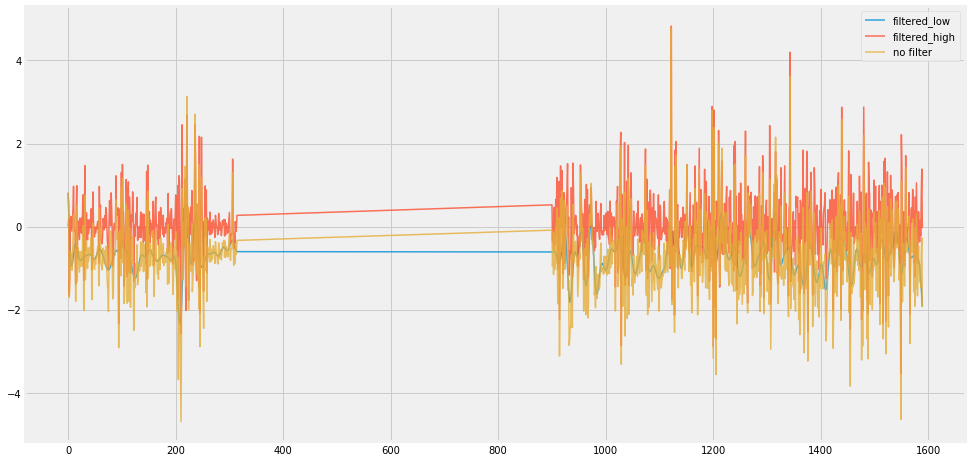

In [34]:
from scipy import signal

plt.figure(figsize=(15, 8))
fc = 50  # cut off frequency of the filter
fs = 750  # sampling frequency
w = fc / (fs / 2)  #
b, a = signal.butter(5, w, 'lowpass')
output = signal.filtfilt(b, a, data_df.loc[data_df.bookingID == 0, 'acceleration_x'])
plt.plot(data_df.loc[data_df.bookingID == 0, 'second'], output, label='filtered_low',
        lw=1.5, alpha=.8)

b, a = signal.butter(5, w, 'highpass')
output = signal.filtfilt(b, a, data_df.loc[data_df.bookingID == 0, 'acceleration_x'])
plt.plot(data_df.loc[data_df.bookingID == 0, 'second'], output, label='filtered_high',
        lw=1.5, alpha=.8)
plt.plot(data_df.loc[data_df.bookingID == 0, 'second'], 
         data_df.loc[data_df.bookingID == 0, 'acceleration_x'], label='no filter',
         lw=1.5, alpha=.8)
plt.legend()
plt.show();

End of the notebook